In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import time
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.contrib.learn.python.learn.datasets import mnist
%matplotlib inline 

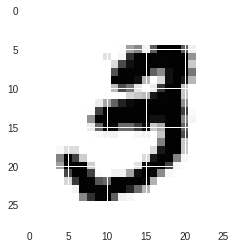

In [4]:
mnist = mnist.read_data_sets('MNIST_data', one_hot=True)
img = np.array(mnist.train.images[753])
plt.imshow(img.reshape(28,28))

In [0]:
def batch_norm(X, scale, offset, axes, is_train,device_name='/cpu:0'):
    # 予測のときにはそのまんまの値を返す
    if is_train is False:
        return X
    
    epsilon = 1e-5
    with tf.device(device_name):
        mean, variance = tf.nn.moments(X, axes)
        bn = tf.nn.batch_normalization(X, mean, variance, offset, scale, epsilon)
        
    return bn

class Generator():
    def __init__(self,device_name='/cpu:0'):
        
        # Generator parameter         
        with tf.device(device_name):
            self.gen_w1 = tf.Variable(tf.truncated_normal(shape=[100,128],stddev=0.02,dtype=tf.float32),name="gen_w1")
            self.gen_b1 = tf.Variable(tf.truncated_normal(shape=[128],stddev=0.02,dtype=tf.float32),name="gen_b1")

            self.gen_w2 = tf.Variable(tf.truncated_normal([128,256],stddev=0.02,dtype=tf.float32),name="gen_w2")
            self.gen_b2 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.02,dtype=tf.float32),name="gen_b2")

            self.gen_w3 = tf.Variable(tf.truncated_normal([256,512],stddev=0.02,dtype=tf.float32),name="gen_w3")
            self.gen_b3 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.02,dtype=tf.float32),name="gen_b3")

            self.gen_w4 = tf.Variable(tf.truncated_normal([512,28*28],stddev=0.02,dtype=tf.float32),name="gen_w4")
            self.gen_b4 = tf.Variable(tf.truncated_normal(shape=[28*28],stddev=0.02,dtype=tf.float32),name="gen_b4")

            self.gen_scale_w1 = tf.Variable(tf.ones([128]),name="gen_scale_w1")
            self.gen_offset_w1 = tf.Variable(tf.zeros([128]),name="gen_offset_w1")

            self.gen_scale_w2 = tf.Variable(tf.ones([256]),name="gen_scale_w2")
            self.gen_offset_w2 = tf.Variable(tf.zeros([256]),name="gen_offset_w2")

            self.gen_scale_w3 = tf.Variable(tf.ones([512]),name="gen_scale_w3")
            self.gen_offset_w3 = tf.Variable(tf.zeros([512]),name="gen_offset_w3")

            self.keep_prob = tf.placeholder(tf.float32)     
        
    def run(self,z,is_train,device_name='/cpu:0'):
        
        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(tf.nn.xw_plus_b(z,self.gen_w1,self.gen_b1),alpha=0.2)
            h1 = batch_norm(h1,self.gen_scale_w1,self.gen_offset_w1,[0],is_train,device_name)

            h2 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h1,self.gen_w2,self.gen_b2),alpha=0.2)
            h2 = batch_norm(h2,self.gen_scale_w2,self.gen_offset_w2,[0],is_train,device_name)

            h3 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h2,self.gen_w3,self.gen_b3),alpha=0.2)
            h3 = batch_norm(h3,self.gen_scale_w3,self.gen_offset_w3,[0],is_train,device_name)
            h3_drop = tf.nn.dropout(h3, self.keep_prob)

            fc = tf.nn.sigmoid(tf.nn.xw_plus_b(h3_drop,self.gen_w4,self.gen_b4))
                
        return fc

class Discrimitor():
    def __init__(self,device_name='/cpu:0'):
        # Discrimitor parameter
        with tf.device(device_name):        
            self.dis_w1 = tf.Variable(tf.truncated_normal([28*28,512],stddev=0.02,dtype=tf.float32),name="dis_w1")
            self.dis_b1 = tf.Variable(tf.truncated_normal([512],stddev=0.02,dtype=tf.float32),name="dis_b1")

            self.dis_w2 = tf.Variable(tf.truncated_normal([512,256],stddev=0.02,dtype=tf.float32),name="dis_w2")
            self.dis_b2 = tf.Variable(tf.truncated_normal([256],stddev=0.02,dtype=tf.float32),name="dis_b2")

            self.dis_w3 = tf.Variable(tf.truncated_normal([256,128],stddev=0.02,dtype=tf.float32),name="dis_w3")
            self.dis_b3 = tf.Variable(tf.truncated_normal([128],stddev=0.02,dtype=tf.float32),name="dis_b3")

            self.dis_w4 = tf.Variable(tf.truncated_normal([128,1],stddev=0.02,dtype=tf.float32),name="dis_w4")
            self.dis_b4 = tf.Variable(tf.truncated_normal([1],stddev=0.02,dtype=tf.float32),name="dis_b4")

        
    def run(self,x,device_name='/cpu:0'):
        
        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(tf.nn.xw_plus_b(x,self.dis_w1,self.dis_b1),alpha=0.2)
            h2 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h1,self.dis_w2,self.dis_b2),alpha=0.2)   
            h3 = tf.nn.leaky_relu(tf.nn.xw_plus_b(h2,self.dis_w3,self.dis_b3),alpha=0.2)

            fc = tf.nn.xw_plus_b(h3,self.dis_w4,self.dis_b4)
                
        return fc
    
class GAN():
    def __init__(self,using_gpu):
        self.device_name = '/cpu:0'
        if(using_gpu):
            self.device_name = '/gpu:0'
        
        print('using : {}'.format(self.device_name))
        
        with tf.device(self.device_name):
            self.is_train = tf.placeholder(tf.bool)
            self.input_X = tf.placeholder(tf.float32, shape=(None,28*28))

            # t0は0のラベルを格納し、t1は1のラベルを格納する
            self.label_t0 = tf.placeholder(tf.float32, shape=(None,1))
            self.label_t1 = tf.placeholder(tf.float32, shape=(None,1))

            # Generator
            self.generator = Generator(device_name=self.device_name)
            # 生成モデルに必要なノイズの入れ物
            self.gen_z = tf.placeholder(tf.float32, shape=(None,100))

            # Discrimitor 
            self.discrimitor = Discrimitor(device_name=self.device_name)

            # weight decay
            gen_norm_term = tf.nn.l2_loss(self.generator.gen_w2) + tf.nn.l2_loss(self.generator.gen_w3) + tf.nn.l2_loss(self.generator.gen_w4)
            gen_lambda_ = 0.001

            dis_norm_term = tf.nn.l2_loss(self.discrimitor.dis_w2) + tf.nn.l2_loss(self.discrimitor.dis_w3)
            dis_lambda_ = 0.001

            # 訓練データの識別予測
            input_X = self.discrimitor.run(self.input_X,device_name=self.device_name)
            # 生成されたデータの識別yosoku
            generated_X = self.discrimitor.run(self.generator.run(z=self.gen_z,is_train=self.is_train,device_name=self.device_name))

            self.dis_entropy_X = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t1, logits=input_X)  
            self.dis_entropy_G = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t0, logits=generated_X)   
            self.dis_loss = tf.reduce_mean(self.dis_entropy_X + self.dis_entropy_G) + dis_norm_term*dis_lambda_

            self.gen_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.label_t1,logits=generated_X)
            self.gen_loss = tf.reduce_mean(self.gen_entropy) + gen_norm_term*gen_lambda_

            # 最適化する際にDならDのみのパラメータを、GならGのみのパラメータを更新するようにしたいのでモデル別の変数を取得する
            dis_vars = [x for x in tf.trainable_variables() if "dis_" in x.name]
            gen_vars = [x for x in tf.trainable_variables() if "gen_" in x.name]

            # 識別モデルDの最適化
            self.opt_d = tf.train.MomentumOptimizer(0.1, momentum=0.5).minimize(self.dis_loss,var_list=[dis_vars])
            # 生成モデルGの最適化
            self.opt_g = tf.train.MomentumOptimizer(0.1, momentum=0.5).minimize(self.gen_loss,var_list=[gen_vars])
        
    def train(self
                  , X_train = None 
                  , batch_size = 100
                  , epoch_num = 1000
                  , imgpath = './mnist_GAN_images/'
                  , ckptpath = './mnist_GAN_checkpoints/'
                  , init = False):
        
        if X_train is None:
            raise TypeError("X_train is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(imgpath)
        if not(p.is_dir()):
            p.mkdir()
        
        # モデルパラメータのチェックポイントの保存先
        ckpt_p = Path(ckptpath)
        if not(ckpt_p.is_dir()):
            ckpt_p.mkdir()
            
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        
        saver = tf.train.Saver()
        
        sess = tf.Session()
        
        if(init):
            sess.run(tf.global_variables_initializer())
            print('Initialize')
            
        ckpt = tf.train.get_checkpoint_state(str(ckpt_p.absolute()))
        if ckpt:
            # checkpointファイルから最後に保存したモデルへのパスを取得する
            last_model = ckpt.model_checkpoint_path
            print("load {0}".format(last_model))
            # 学習済みモデルを読み込む
            saver.restore(sess, last_model)        
            
        step = len(X_train) // batch_size
        #step = mnist.train.num_examples // batch_size
        
        # 正解ラベルのミニバッチ
        t1_batch = np.ones((batch_size,1),dtype=np.float32)
        t0_batch = np.zeros((batch_size,1),dtype=np.float32)

        for epoch in range(epoch_num):            
            
            perm = np.random.permutation(len(X_train))
            # １エポックごとにかかる時間の計測
            start = time.time()
            for k in range(step):
                #X_batch = mnist.train.next_batch(batch_size)[0] /255.
                X_batch = X_train[perm][k*batch_size:(k+1)*batch_size]
                
                # Train Discrimitor
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(-1,1, size=[batch_size, 100]).astype(np.float32)

                sess.run(self.opt_d, feed_dict = {self.input_X:X_batch
                                                                          , self.is_train:False
                                                                          , self.gen_z:noise_z
                                                                          , self.generator.keep_prob:1.0
                                                                          , self.label_t1:t1_batch
                                                                          , self.label_t0:t0_batch})
                
                #if k % (step//10) == 0:
                # Train Generator
                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(-1,1, size=[batch_size, 100]).astype(np.float32)
                sess.run(self.opt_g, feed_dict = {self.gen_z:noise_z
                                                                          , self.is_train:True
                                                                          , self.generator.keep_prob:0.5
                                                                          , self.label_t1:t1_batch})
            
            # 1epoch終了時の損失を表示
            noise_z = np.random.uniform(-1,1, size=[batch_size, 100]).astype(np.float32)
            train_dis_loss = sess.run(self.dis_loss, feed_dict = {self.input_X:X_batch
                                                                                                      , self.is_train:False
                                                                                                      , self.gen_z:noise_z
                                                                                                      , self.generator.keep_prob:1.0
                                                                                                      , self.label_t1:t1_batch
                                                                                                      , self.label_t0:t0_batch})

            train_gen_loss = sess.run(self.gen_loss, feed_dict ={self.gen_z:noise_z
                                                                                                      , self.is_train:False
                                                                                                      , self.generator.keep_prob:1.0
                                                                                                      , self.label_t1:t1_batch})

            print("[Train] epoch: %d, dis loss: %f , gen loss : %f  Time : %f" % (epoch, train_dis_loss, train_gen_loss, time.time() - start))
            
            saver.save(sess, str(ckpt_p.absolute())+'/GAN-mnist')
            
            # 10epoch終了毎に生成モデルから1枚の画像を生成する
            if epoch % 10 == 0:
                noise_z = np.random.uniform(-1,1, size=[1, 100]).astype(np.float32)

                z_const = tf.constant(noise_z,dtype=tf.float32)
                gen_imgs = sess.run(self.generator.run(z_const, is_train=False),feed_dict={self.generator.keep_prob:1.0}) * 255
                Image.fromarray(gen_imgs[0].reshape(28,28)).convert('RGB').save(
                        str(p.absolute())+'/generate_img_epoch{0}.jpg'.format(epoch)
                )

In [0]:
X_train = np.r_[mnist.train.images,mnist.test.images] / 255.

In [9]:
model = GAN(using_gpu=True)
model.train(X_train=X_train,batch_size=100, epoch_num=10, init=True)

using : /gpu:0
Initialize
[Train] epoch: 0, dis loss: 1.416150 , gen loss : 0.868893  Time : 55.745630
[Train] epoch: 1, dis loss: 1.400458 , gen loss : 0.846972  Time : 55.044122
[Train] epoch: 2, dis loss: 1.396470 , gen loss : 0.825828  Time : 54.647170
[Train] epoch: 3, dis loss: 1.396191 , gen loss : 0.808788  Time : 54.802599
[Train] epoch: 4, dis loss: 1.394601 , gen loss : 0.795847  Time : 55.008549
[Train] epoch: 5, dis loss: 1.393527 , gen loss : 0.785292  Time : 54.996431
[Train] epoch: 6, dis loss: 1.388596 , gen loss : 0.778265  Time : 54.822872
[Train] epoch: 7, dis loss: 1.385105 , gen loss : 0.776123  Time : 54.498708
[Train] epoch: 8, dis loss: 1.390166 , gen loss : 0.760478  Time : 54.715502
[Train] epoch: 9, dis loss: 1.387348 , gen loss : 0.754641  Time : 54.450168


In [12]:
model.train(X_train=X_train,batch_size=100, epoch_num=10, init=False)

load /content/mnist_GAN_checkpoints/GAN-mnist
INFO:tensorflow:Restoring parameters from /content/mnist_GAN_checkpoints/GAN-mnist
[Train] epoch: 0, dis loss: 1.384992 , gen loss : 0.753092  Time : 55.415228
[Train] epoch: 1, dis loss: 1.388160 , gen loss : 0.750115  Time : 54.569854
[Train] epoch: 2, dis loss: 1.385454 , gen loss : 0.748116  Time : 54.579363
[Train] epoch: 3, dis loss: 1.386948 , gen loss : 0.745432  Time : 54.586129
[Train] epoch: 4, dis loss: 1.387257 , gen loss : 0.743630  Time : 54.522468
[Train] epoch: 5, dis loss: 1.386093 , gen loss : 0.743958  Time : 54.592989
[Train] epoch: 6, dis loss: 1.386804 , gen loss : 0.740215  Time : 54.668722
[Train] epoch: 7, dis loss: 1.385283 , gen loss : 0.736444  Time : 54.638287
[Train] epoch: 8, dis loss: 1.387362 , gen loss : 0.732796  Time : 54.082628
[Train] epoch: 9, dis loss: 1.385418 , gen loss : 0.736565  Time : 53.582535


In [19]:
!zip -r mnist_GAN_checkpoints.zip mnist_GAN_checkpoints

  adding: mnist_GAN_checkpoints/ (stored 0%)
  adding: mnist_GAN_checkpoints/GAN-mnist.meta (deflated 88%)
  adding: mnist_GAN_checkpoints/checkpoint (deflated 53%)
  adding: mnist_GAN_checkpoints/GAN-mnist.index (deflated 51%)
  adding: mnist_GAN_checkpoints/GAN-mnist.data-00000-of-00001 (deflated 7%)


In [21]:
!zip -r mnist_GAN_images.zip mnist_GAN_images

  adding: mnist_GAN_images/ (stored 0%)
  adding: mnist_GAN_images/generate_img_epoch40.jpg (deflated 27%)
  adding: mnist_GAN_images/generate_img_epoch30.jpg (deflated 26%)
  adding: mnist_GAN_images/generate_img_epoch160.jpg (deflated 21%)
  adding: mnist_GAN_images/generate_img_epoch150.jpg (deflated 25%)
  adding: mnist_GAN_images/generate_img_epoch20.jpg (deflated 27%)
  adding: mnist_GAN_images/generate_img_epoch90.jpg (deflated 24%)
  adding: mnist_GAN_images/generate_img_epoch130.jpg (deflated 25%)
  adding: mnist_GAN_images/generate_img_epoch10.jpg (deflated 27%)
  adding: mnist_GAN_images/generate_img_epoch80.jpg (deflated 25%)
  adding: mnist_GAN_images/generate_img_epoch140.jpg (deflated 23%)
  adding: mnist_GAN_images/generate_img_epoch170.jpg (deflated 25%)
  adding: mnist_GAN_images/generate_img_epoch100.jpg (deflated 22%)
  adding: mnist_GAN_images/generate_img_epoch60.jpg (deflated 26%)
  adding: mnist_GAN_images/generate_img_epoch50.jpg (deflated 26%)
  adding: mnist_

In [0]:
from google.colab import files
files.download('mnist_GAN_images.zip')